In [1]:
! pip install textblob

In [2]:
! pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)


## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  confusion_matrix, roc_curve, roc_auc_score

from imblearn.under_sampling import RandomUnderSampler

from sklearn import metrics

from scipy.stats import chi2_contingency

from textblob import TextBlob

%matplotlib inline

## Importing Dataset

In [4]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Data Preprocessing

### Removing Spaces from Column Names

In [5]:
col_names = df.columns.str.replace(' ','')
col_names
df.columns = col_names

In [6]:
df.drop(columns='Unnamed:0' , inplace= True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ClothingID             23486 non-null  int64 
 1   Age                    23486 non-null  int64 
 2   Title                  19676 non-null  object
 3   ReviewText             22641 non-null  object
 4   Rating                 23486 non-null  int64 
 5   RecommendedIND         23486 non-null  int64 
 6   PositiveFeedbackCount  23486 non-null  int64 
 7   DivisionName           23472 non-null  object
 8   DepartmentName         23472 non-null  object
 9   ClassName              23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


### Missing Values

<AxesSubplot:title={'center':'Missing Columns'}, ylabel='% missing'>

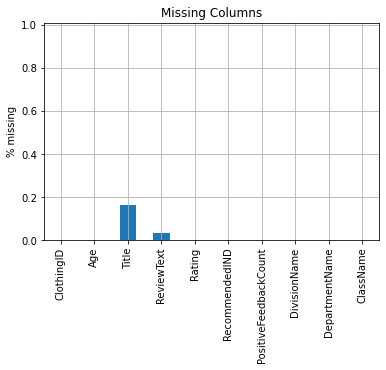

In [8]:
missing_percent = df.isna().sum(axis=0)
missing_percent = missing_percent/df.shape[0]
missing_percent.plot(kind='bar',
                     title = 'Missing Columns',
                     ylabel = '% missing',
                     ylim = (0,1.01),
                     grid = True)

#### Dropping Missing Values Because they are Low

In [9]:
df.dropna(inplace= True)

In [10]:
df.isna().sum()

ClothingID               0
Age                      0
Title                    0
ReviewText               0
Rating                   0
RecommendedIND           0
PositiveFeedbackCount    0
DivisionName             0
DepartmentName           0
ClassName                0
dtype: int64

### Remove Items that have been reviewed less than 5 times

In [11]:
review_count = df['ClothingID'].value_counts()

print("Maximum Number of Reviews ", review_count.max())
print("Maximum Number of Reviews ", review_count.min())

Maximum Number of Reviews  871
Maximum Number of Reviews  1


In [12]:
df = df.groupby('ClothingID').filter(lambda x : x['ClothingID'].shape[0]>5)

In [13]:
review_count = df['ClothingID'].value_counts()

print("Maximum Number of Reviews ", review_count.max())
print("Maximum Number of Reviews ", review_count.min())

Maximum Number of Reviews  871
Maximum Number of Reviews  6


### Removing Special Characters

In [14]:
special_characters = ['!','#','$','%', '&','@','[',']','_',',','.']
for _,ch in enumerate(special_characters):
    df['ReviewText'] = df['ReviewText'].str.replace(ch,'',regex=True)

### Converting Review Text to Lower Text

In [15]:
df['ReviewText'] = df['ReviewText'].str.lower()

### Removing Contractions

In [16]:
contractions = {
"a'ight":"alright",
"ain't":"are not",
"amn't":"am not",
"aren't":"are not",
"can't":"cannot",
"'cause": "because",
"could've":"could have",
"couldn't":"could not",
"couldn't've":"could not have",
"daren't":"dare not",
"daresn't":"dare not",
"dasn't":"dare not",
"didn't":"did not",
"doesn't":"does not",
"don't":"do not",
"everybody's":"everybody is",
"everyone's":"everyone is",
"giv'n":"given",
"gonna":"going to",
"gon't":"go not", 
"gotta":"got to",
"hadn't":"had not",
"had've":"had have",
"hasn't":"has not",
"haven't":"have not",
"he'd":"he had", 
"he'll":"he will",
"he's":"he is",
"here's":"here is",
"how'd":"how did",
"how'll":"how will",
"how're":"how are",
"how's":"how is",
"I'd":"I had",
"I'd've":"I would have",
"I'd'nt":"I would not",
"I'd'nt've":"I would not have",
"I'll":"I will",
"I'm":"I am",
"I've":"I have",
"isn't":"is not",
"it'd":"it would",
"it'll":"it will",
"it's":"it is",
"let's":"let us",
"ma'am":"madam",
"mayn't":"may not",
"may've":"may have",
"mightn't":"might not",
"might've":"might have",
"mustn't":"must not",
"mustn't've":"must not have",
"must've":"must have",
"needn't":"need not",
"needn't've":"need not have",
"o'clock":"of the clock",
"oughtn't":"ought not",
"oughtn't've":"ought not have",
"shan't":"shall not",
"she'd":"she would",
"she'll":"she will",
"she's":"she is",
"should've":"should have",
"shouldn't":"should not",
"shouldn't've":"should not have",
"somebody's":"somebody is",
"someone's":"someone is",
"something's":"something is",
"so're":"so are",
"so’s":"so is",
"so’ve":"so have",
"that'll":"that will",
"that're":"that are",
"that's":"that is",
"that'd":"that would",
"there'd":"there would",
"there'll":"there will",
"there're":"there are",
"there's":"there is",
"these're":"these are",
"these've":"these have",
"they'd":"they would",
"they'll":"they will",
"they're":"they are",
"they've":"they have",
"this's":"this is",
"those're":"those are",
"those've":"those have",
"to've":"to have",
"wasn't":"was not",
"we'd":"we would",
"we'd've":"we would have",
"we'll":"we will",
"we're":"we are",
"we've":"we have",
"weren't":"were not",
"what'd":"what did",
"what'll":"what will",
"what're":"what are",
"what's":"what is",
"what've":"what have",
"when's":"when is",
"where'd":"where did",
"where'll":"where will",
"where're":"where are",
"where's":"where is",
"where've":"where have",
"which'd":"which would",
"which'll":"which will",
"which're":"which are",
"which's":"which is",
"which've":"which have",
"who'd":"who would",
"who'd've":"who would have",
"who'll":"who will",
"who're":"who are",
"who's":"who is",
"who've":"who have",
"why'd":"why did",
"why're":"why are",
"why's":"why is",
"won't":"will not",
"would've":"would have",
"wouldn't":"would not",
"wouldn't've":"would not have",
"y'at":"you at",
"yes’m":"yes madam",
"you'd":"you would",
"you'll":"you will",
"you're":"you are",
"you've":"you have"}

In [17]:
def cont_to_exp(x):
    if type(x) is str:
        x = x.replace('\\','')
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [18]:
df['ReviewText'] = df['ReviewText'].apply(lambda x:cont_to_exp(x))

### Performing Sentiment Anaysis

In [19]:
df['polarity'] = df['ReviewText'].apply(lambda x : TextBlob(x).sentiment.polarity)
df['review_len'] = df['ReviewText'].apply(lambda x: len(x))
df['word_count'] = df['ReviewText'].apply(lambda x: len(x.split()))
df['avg_word_len'] = df['review_len']/df['word_count']

## Feature Selection

### Checking Relevant Attributes
- attributes with p value < 0.05 will be considered

In [20]:
recomm_pol_ct = pd.crosstab(index=df['RecommendedIND'] , columns=df['polarity'])
c , p , dof , expected = chi2_contingency(recomm_pol_ct) 
print("P value between RecommendedIND and polarity is {0:2.10f}".format(p))

P value between RecommendedIND and polarity is 0.0000000000


In [21]:
words_pol_ct = pd.crosstab(index=df['RecommendedIND'] , columns=df['word_count'])
c , p , dof , expected = chi2_contingency(words_pol_ct) 
print("P value between RecommendedIND and word_count is {0:2.10f}".format(p))

P value between RecommendedIND and word_count is 0.0001172387


In [22]:
revLen_pol_ct = pd.crosstab(index=df['RecommendedIND'] , columns=df['review_len'])
c , p , dof , expected = chi2_contingency(revLen_pol_ct) 
print("P value between RecommendedIND and review_len is {0:2.10f}".format(p))

P value between RecommendedIND and review_len is 0.1719138150


In [23]:
wrdLen_pol_ct =  pd.crosstab(index=df['RecommendedIND'] , columns=df['avg_word_len'])
c , p , dof , expected = chi2_contingency(wrdLen_pol_ct) 
print("P value between RecommendedIND and avg_word_len is {0:2.10f}".format(p))

P value between RecommendedIND and avg_word_len is 0.6528648930


## Train Test Split

In [24]:
X = df[['Age','Rating','PositiveFeedbackCount','DepartmentName','polarity','review_len']]
y = df['RecommendedIND']
X_train , X_test , y_train , y_test = train_test_split( X , y , test_size = 0.2 , random_state=42)

## Check if classes are balanced

<AxesSubplot:>

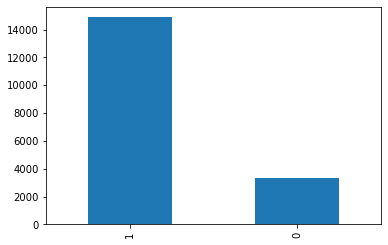

In [27]:
y.value_counts().plot(kind='bar')

- Unbalanced Classes


In [28]:
under_sampler = RandomUnderSampler(random_state=42)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

<AxesSubplot:>

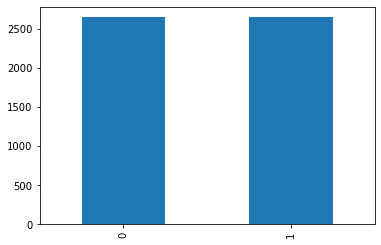

In [29]:
y_train.value_counts().plot(kind='bar')

### Classes are now Balanced

## Data Pipelines

### Creating Nominal and Numerical Pipelines

In [30]:
nominal = ['DepartmentName']
numerical = ['Age','Rating','PositiveFeedbackCount','polarity','review_len']

In [31]:
nominal_pipeline = Pipeline([
    ('imputer_n' , SimpleImputer(strategy='most_frequent')),
    ('encoder_n', OneHotEncoder(sparse=True, handle_unknown="ignore"))
])

numerical_pipeline = Pipeline([
    ('imputer_nu' , SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

## Train 2 Models

In [32]:
preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor', nominal_pipeline, nominal),
    ('numerical_preprocessor', numerical_pipeline, numerical)
])

### GaussianNB

In [33]:
gaussian_nb_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('GaussianNB',GaussianNB())
])

### BernoulliNB

In [34]:
bernoulli_nb_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('GaussianNB',BernoulliNB())
])

### Scores

In [35]:
cross_val = KFold(n_splits = 10)
scores = cross_val_score(bernoulli_nb_pipeline, X = X_train , y = y_train , cv = cross_val)

In [36]:
print("Bernoulli Naive Bayes Accuracy is {0:2.2f}%".format(scores.mean()*100))

Bernoulli Naive Bayes Accuracy is 94.26%


In [37]:
cross_val = KFold(n_splits = 10)
scores = cross_val_score(gaussian_nb_pipeline, X = X_train , y = y_train , cv = cross_val)

In [39]:
print("Gaussian Naive Bayes Accuracy is {0:2.2f}%".format(scores.mean()*100))

Gaussian Naive Bayes Accuracy is 93.54%


### Confusion Matrix

In [41]:
model2 = bernoulli_nb_pipeline.fit(X_train,y_train)
model2.score(X_test,y_test)

model = gaussian_nb_pipeline.fit(X_train,y_train)
model.score(X_test,y_test)

0.9225700164744646

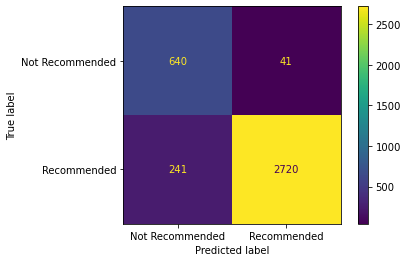

In [42]:
cm = confusion_matrix(y_true=y_test , y_pred=model.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=['Not Recommended','Recommended']).plot()

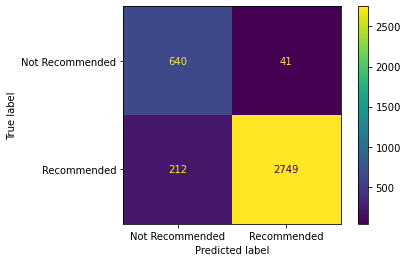

In [43]:
cm = confusion_matrix(y_true=y_test , y_pred=model2.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=['Not Recommended','Recommended']).plot()

### Accuracy Metrics

In [44]:
print(metrics.classification_report(y_test, y_pred = model.predict(X_test), labels = [0,1] , target_names=['Not Recommended','Recommended']))

                 precision    recall  f1-score   support

Not Recommended       0.73      0.94      0.82       681
    Recommended       0.99      0.92      0.95      2961

       accuracy                           0.92      3642
      macro avg       0.86      0.93      0.89      3642
   weighted avg       0.94      0.92      0.93      3642



In [45]:
print(metrics.classification_report(y_test, y_pred = model2.predict(X_test), labels = [0,1] , target_names=['Not Recommended','Recommended']))

                 precision    recall  f1-score   support

Not Recommended       0.75      0.94      0.83       681
    Recommended       0.99      0.93      0.96      2961

       accuracy                           0.93      3642
      macro avg       0.87      0.93      0.90      3642
   weighted avg       0.94      0.93      0.93      3642



### ROC Curves

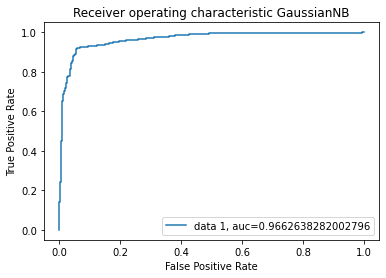

In [46]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize = (6,4))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic GaussianNB')
plt.legend(loc="lower right")

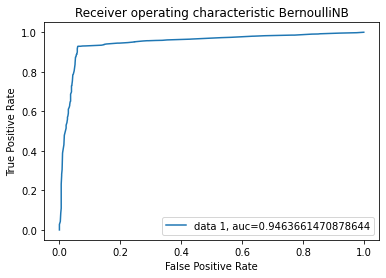

In [47]:
y_pred_proba = model2.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize = (6,4))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic BernoulliNB')
plt.legend(loc="lower right")

### Inference
- we get an AUC = 0.96 for GaussianNB which is slightly better than AUC = 0.94 of BernoulliNB.  
- This means GaussianNB is a MUCH better classifier than BernoulliNB.  
- Since the data will be used in recommender systems, we want high precision
- We should thus prioritise Precision over Recall in this case